# Analytical and numerical calculation of the order of approximation of a derivative calculated through finite differences (optional).

## 1 – The numerical test of the high-order formula

Implement the finite difference formula given by the first term on the right of Eq (5) in the [wiki](https://github.com/AST-Course/AST5110/wiki/Discretization)  into the program you developed for Exercise 1a and test if you get an approximation to the first derivative with an error that converges to zero like $(\Delta x)^4$.

Compare the 2nd-order and 4th-order error curves. Which error do you get in either case for 128 intervals? For 512 intervals? For 1024 intervals?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from nm_lib import nm_lib as nm
# Define some simple global matplotlib settings
plt.rcParams.update(
    {"font.size" : "15",
     "font.family"          : "STIXGeneral",
     "mathtext.fontset"     : "stix",
     "figure.autolayout"    : "True",
     "figure.figsize"       : (7,7),
     "lines.markersize"     : 10,
     }
)

def get_xx(nint: int, xf: float = 10.0, x0: float = -4.0) -> tuple[np.ndarray, float]:
    """
    Generate an array of x values from x0 to xf with nint number of intervals between points

    Arguments:
        nint {int} -- number of intervals between grid points

    Keyword Arguments:
        xf {float} -- last value in output array (default: {10.0})
        x0 {float} -- first value in output array (default: {-4.0})

    Returns:
        tuple[np.ndarray, float] -- (the resulting x array, spacing between points x[1]-x[0])
    """
    x = np.arange(nint+1)/nint * (xf-x0) + x0
    return x, x[1]-x[0]

def get_h(x: np.ndarray) -> np.ndarray:
    """
    Compute the value of test function (eq. 1) along input array x

    Arguments:
        x {np.ndarray} -- coordinate to compute function values along

    Returns:
        np.ndarray -- the resulting function values
    """
    return np.cos(np.pi*(x-1)/2)*np.exp(-((x-3)/2.5)**2)

def get_hp_analytic(x: np.ndarray) -> np.ndarray:
    """
    Computes the analytical first derivative of test function (eq. 1) along input array x

    Arguments:
        x {np.ndarray} -- coordinate to compute the derivative along

    Returns:
        np.ndarray -- the resulting derivative values
    """
    return np.exp(-0.16*(x-3)**2) * (1.5708*np.cos(np.pi*x/2) - (0.32*x-0.96)*np.sin(np.pi*x/2))

def get_abs_err(xx: np.ndarray, dx: float, deriv_type: str, h_of_x: callable = get_h, hp_analytical: callable = get_hp_analytic) -> np.ndarray:
    """
    Computes the abs error of a type of numerical derivative against the analytical derivative
    evaluated at appropriate xx points.

    Arguments:
        hh {np.ndarray} -- values of function to compute the derivate of
        xx {np.ndarray} -- coordinate to compute the derivative along
        dx {float} -- coordinate grid spacing, used to offsett the computation of the analytical derivative
        deriv_type {str} -- type of numerical derivative, supports [4tho, upw, dnw, cent]

    Keyword Arguments:
        h_of_x {callable} -- function to evaluate the derivate of, must return np.ndarray
        hp_analytical {callable} -- function to evaluate the analytical derivative, must return np.ndarray

    Returns:
        np.ndarray -- the absolute value of the difference between analytical and numerical derivative
    """
    hh = h_of_x(xx)
    if deriv_type == "4tho":
        hp_a = hp_analytical(xx)
        hp = nm.deriv_4tho(xx, hh, method="roll")
    elif deriv_type == "upw":
        hp_a = hp_analytical(xx+dx/2)
        hp = nm.deriv_upw(xx, hh, method="roll")
    elif deriv_type == "dnw":
        hp_a = hp_analytical(xx-dx/2)
        hp = nm.deriv_dnw(xx, hh, method="roll")
    elif deriv_type == "cent":
        hp_a = hp_analytical(xx)
        hp = nm.deriv_cent(xx, hh, method="roll")
    return np.abs(hp_a-hp)

def get_max_abs_err(xx: np.ndarray, dx: float, deriv_type: str, h_of_x: callable = get_h, hp_analytical: callable = get_hp_analytic) -> float:
    """
    Compute the maximum absolute error of a type of numerical derivative against the analytical derivative
    evaluated at appropriate xx points, excluding ill behaved boundary points.

    Requires:
        get_abs_err() which computes the absolute error

    Arguments:
        hh {np.ndarray} -- values of function to compute the derivate of
        xx {np.ndarray} -- coordinate to compute the derivative along
        dx {float} -- coordinate grid spacing, used to offsett the computation of the analytical derivative
        deriv_type {str} -- type of numerical derivative, supports [4tho, upw, dnw, cent]

    Keyword Arguments:
        h_of_x {callable} -- function to evaluate the derivate of, must return np.ndarray
        hp_analytical {callable} -- function to evaluate the analytical derivative, must return np.ndarray

    Returns:
        float -- the maximum aboslute error of the numerical derivative
    """
    if deriv_type == "4tho":
        bounds = slice(2,-2)
    elif deriv_type == "upw":
        bounds = slice(None,-1)
    elif deriv_type == "dnw":
        bounds = slice(1,None)
    elif deriv_type == "cent":
        bounds = slice(1,-1)
    return np.max(get_abs_err(xx, dx, deriv_type, h_of_x, hp_analytical)[bounds])

def check_err_conv(nints: np.ndarray, deriv_types: list[str] = ["4tho"], plot: bool = True, dtype: np.dtype = np.float64) -> tuple[np.ndarray, np.ndarray]:
    """
    Computes the maximum absolute error of a type of numerical derivative given a number of intervals
    in the grid for the coordinate to compute the derivate along. Returns the error as well as the grid size.
    If plot keyword argument is True it also plots the log error against a inversed log grid sampling size.

    Requires:
        get_max_abs_err() which computes the maximum absolute error

    Arguments:
        nints {np.ndarray} -- integer values for the number of intervals in the grid

    Keyword Arguments:
        deriv_types {list[str]} -- a list of strings holding the types of derivative to compute, supports [4tho, upw, dnw, cent] (default: {["4tho"]})
        plot {bool} -- controlls whether or not to plot the results (default : {True})

    Returns:
        tuple[np.ndarray, np.ndarray] -- 1) (len(nints), len(deriv_types)) array holding the max abs error
                                         2) (len(nints)) array holding the grid size 
    """
    dxs = np.zeros(len(nints), dtype=dtype)
    maxerrs = np.vstack((np.zeros_like(dxs),)*len(deriv_types))
    
    for col, nint in enumerate(nints):
        xx, dxs[col] = get_xx(nint)
        xx = dtype(xx)
        for row, deriv_type in enumerate(deriv_types):
            maxerrs[row, col] = get_max_abs_err(xx, dxs[col], deriv_type)
    if plot:
        fig, ax = plt.subplots()
        markers = [str(x) for x in range(1,8)]
        for row, deriv_type in enumerate(deriv_types):
            ax.loglog(dxs, maxerrs[row,:], marker=markers[row], label=deriv_type)
        ax.invert_xaxis()
        ax.legend()
        ax.grid()
        ax.set_xlabel("$\Delta x$")
        ax.set_ylabel("max abs error")
        ax.set_xticks(dxs, [f"{val:.2e}" for val in dxs], rotation=45)
        nintax = ax.twiny()
        nintax.loglog(nints, np.zeros_like(nints))
        nintax.set_xticks(nints, [f"{val:d}" for val in nints], rotation=45)
        nintax.set_xlabel("nints")
        ax.xaxis.set_tick_params(which="minor", bottom=False)
        nintax.xaxis.set_tick_params(which="minor", top=False)

    return maxerrs, dxs



Ratio cent/upw [4.10532852 3.70418435 3.95173588 3.96819711 3.98656867 3.94174396
 3.78213753 3.28071205 2.31248885 1.47567834 1.13140407 1.0335297
 1.00841864 1.00210693 1.00052459]


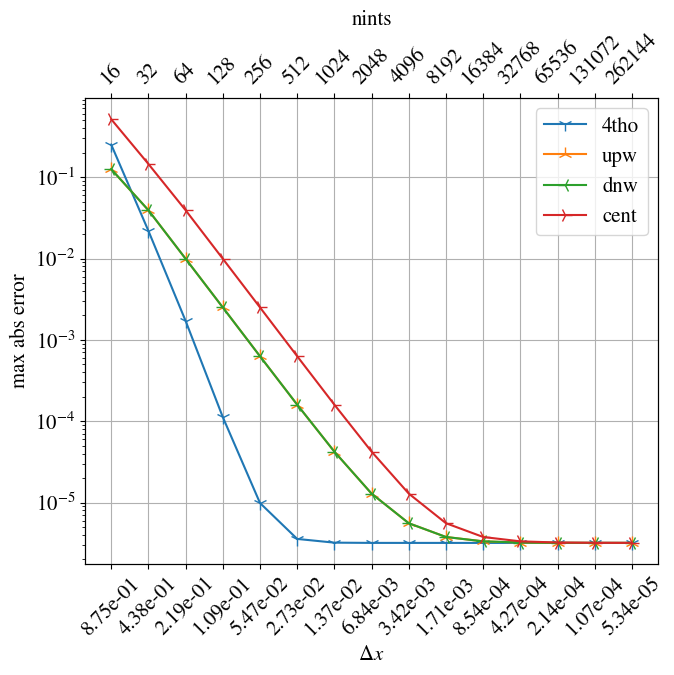

In [2]:
if __name__ == "__main__":
    log_nint_low = 4
    log_nint_high = 18
    nints = np.logspace(log_nint_low, log_nint_high, int(log_nint_high-log_nint_low)+1, base=2, dtype=int)
    maxerrs, dxs = check_err_conv(nints, ["4tho", "upw", "dnw", "cent"]);
    print("Ratio cent/upw", maxerrs[3,:]/maxerrs[1,:]);

In [3]:
if __name__ == "__main__":
    nints = [128, 256, 512, 1024]
    deriv_types = ["4tho", "upw"]
    maxerrs, dxs = check_err_conv(nints, deriv_types=deriv_types, plot=False)
    print(f"{'log10 error and difference':^75s}")
    print("-"*75)
    print(f"{'nints':^15s}"+"".join(f"|{val:^15d}" for val in nints))
    for row, deriv_type in enumerate(deriv_types):
        print(f"{deriv_type:^15s}"+"".join(f"|{val:^15.3e}" for val in np.log10(maxerrs[row])))
    print(f"{'diff':^15s}"+"".join(f"|{val:^15.3e}" for val in np.abs(np.log10(maxerrs[0])-np.log10(maxerrs[1]))))

                        log10 error and difference                         
---------------------------------------------------------------------------
     nints     |      128      |      256      |      512      |     1024      
     4tho      |  -3.949e+00   |  -5.006e+00   |  -5.448e+00   |  -5.493e+00   
      upw      |  -2.601e+00   |  -3.202e+00   |  -3.797e+00   |  -4.375e+00   
     diff      |   1.348e+00   |   1.805e+00   |   1.651e+00   |   1.119e+00   


### Comments
Here I repeat the test of the maximum absolute error from the previous exercise, but include both the 4th order central differencing and the 2nd order central differencing methods. I've also wrapped the computation into three different functions, the idea being that the same procedure can be repeated easily in the future. First two for calculating the absolute error and the maximum absolute error (excluding the ill calculated points) given input callables for the function it self and the analytical derivative -- the test functions (eq 1) is provided by default. The type of derivative is also given as an input string, which controls which numerical derivative is used and computes the analytical results on appropriate grid point values according to the derivative type, and finally exclude the ill calculated boundary points from the maximum value. The last functions is just utilizing this functionality and loops over an array of number of intervals and plots it with some formatting.

It's relatively easy to see by eye that the upwind, downwind and central 2nd order derivatives goes as $(\Delta x)^2$ as the error decreases by two orders of magnitude for a one order of magnitude decrease in $\Delta x$. with for the 4th order method, the error is reduced by four orders of magnitude over the same span in $\Delta x$. 

Im think my implementation of the central 2nd order derivative is wrong, as the error is about 4 times larger than the upwind and downwind methods for lower number of points. But the slope of the error still follows approximately as expected, and for higher number of points the error converges to the same value as the other methods.

Regarding the convergence, we see that the 4th order reaches this value more rapidly, as expected, but that all the methods converge to the same value. This indicate to me that the error I get for large number of points is not due to the methods themselves, but rather numerical limitations of floating-point values. I will try to comment more about this in the next task.

Finally, for the specific values of `[128, 512, 1024]` we see that the largest difference in log-space between the two methods is at `nint=512`. I've also added the `nint=256` as I saw in the previous plot it actually produces the biggest difference. I understand this by thinking of the order of the different methods, and that the 4th order method starts to converge at `nint=256`, while the 2nd starts around `nint=4096`. Before `nint=256` the difference between the two methods increases due to their $\Delta x$ dependence (excluding `nint=16`), but as they converge to the same value the difference decreases when the 4th order start to converge.

## 2 - Precission

Try for more than $10^6$ grid points. What do you see? What happens if you try for a lower or higher floating number? Numpy uses float 64 as default. Instead, use `np.float32` and `np.float128` (note: `np.float128` sometimes gives an error with `np.roll`!). Explain the error slopes. 

Error using float32
Check type output float32


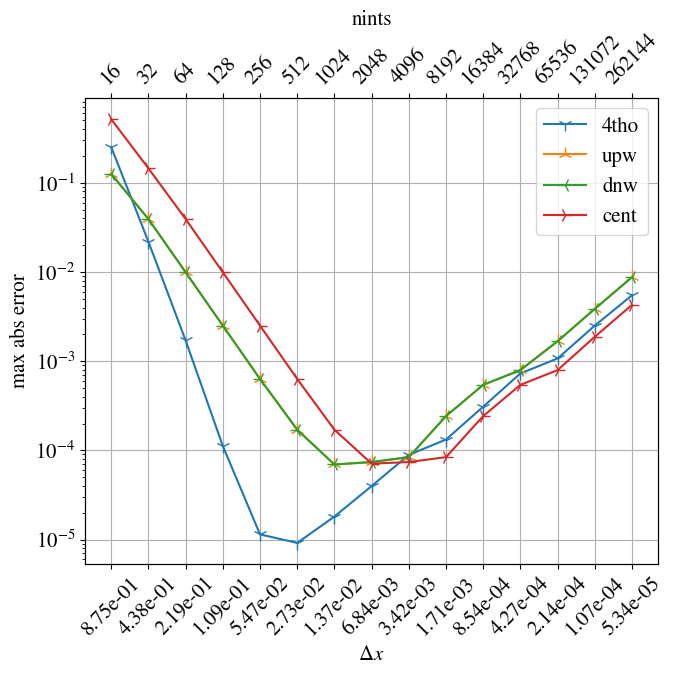

In [4]:
if __name__ == "__main__":
    log_nint_low = 4
    log_nint_high = 18
    nints = np.logspace(log_nint_low, log_nint_high, int(log_nint_high-log_nint_low)+1, base=2, dtype=int)
    print("Error using float32")
    maxerrs, dxs = check_err_conv(nints, ["4tho", "upw", "dnw", "cent"], dtype=np.float32)
    print("Check type output", maxerrs.dtype)

Error using float128
Check type output float128


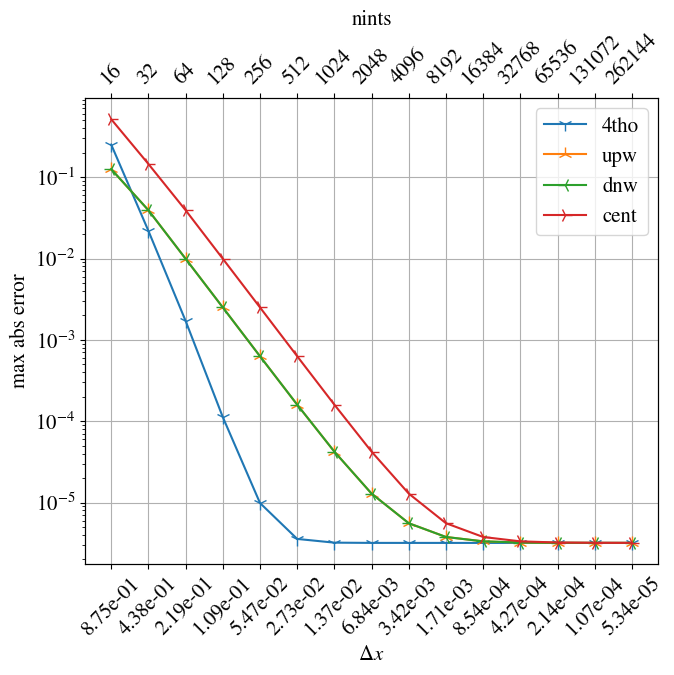

In [5]:
if __name__ == "__main__":
    log_nint_low = 4
    log_nint_high = 18
    nints = np.logspace(log_nint_low, log_nint_high, int(log_nint_high-log_nint_low)+1, base=2, dtype=int)
    print("Error using float128")
    maxerrs, dxs = check_err_conv(nints, ["4tho", "upw", "dnw", "cent"], dtype=np.float128)
    print("Check type output", maxerrs.dtype)

### Comments
Here we clearly see how the floating-point representation of numerical values can cause problems. First, without further testing I can see no noticeable difference between `float128` and `float64`, which goes to show why 64bit-representation is the default for `numpy`. For the 32bit we see that for increasingly number of points above a certain value for each method the error starts to increase. 

Here I must be honest and say I somewhat struggle to differentiate "floating point errors" and "roundoff errors", as to my understanding both are caused by the fact that we use _floating point_ values. My understanding at this time goes as follows:

"Floating point errors" is caused by the fact that we have a finite number of bits to represent any given number. That means there is a scale at which two numbers which is very close together is not properly distinguishable using floating point numbers. If we want to find the difference between those two numbers the result is ill-behaved, as we need more bits than available to represent the difference. Especially subtraction is susceptible to this kind of error. A simple demonstration follows under here with the use of `np.linspace`, which should produce arrays with _equally_ spaced points `dx`. Notice that the error is quite small, but the most important part is that it oscillates uncontrollably. I think this is what happens for the `np.float32` case.

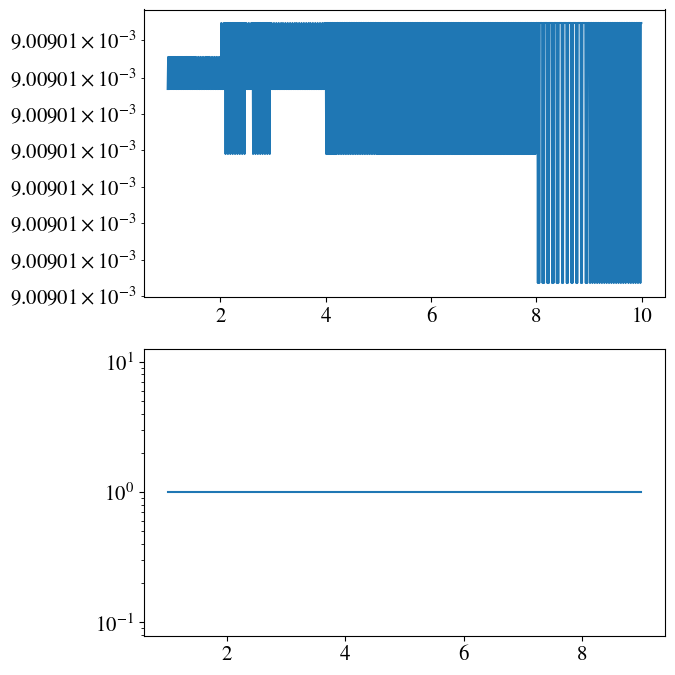

In [6]:
if __name__ == "__main__":
    x = np.linspace(1,10,1000)   # too large grid
    dx = x[1:]-x[:-1]
    fig, ax = plt.subplots(nrows=2)
    ax[0].semilogy(x[:-1], dx)
    x = np.linspace(1,10,10)    # small enough grid
    dx = x[1:]-x[:-1]
    ax[1].semilogy(x[:-1], dx);

On the other hand, also due to the limitations of how many bits are available to represent a given number, round off errors may occur for example if we deal with two numbers of largely different amplitude. An over-simplified example of this follows bellow. If we add or subtract a small number to/from a large number, we dont have enough precision to represent the new value. This could for example happen near the point where the function `h(x)` is close to zero. From the task where we plotted the absolute error in the previous exercise, we see that the largest absolute error happens around where `h(x)=0` and the derivative is at it's extreme points. Here we could have `h(x+dx)` being large compared to `h(x)!=0` so that `h(x+dx) - h(x)=h(x+dx)` because of loss of precision. I think this is why the error of my methods converges to the same value.

In [7]:
if __name__ == "__main__":
    large = 2.62e9
    small = 4e-9
    diff = large-small
    add = large + small
    print("diff",diff)
    print("add", add)
    print("equal", diff==add)

diff 2620000000.0
add 2620000000.0
equal True


<span style="color:green">JMS</span>.

<span style="color:blue">GREAT JOB! very detailed description. To clarify, floating error or value is the precision that one variable can reach, and round off error is the error produced by the operations of variables with very different values. Those operactions can lead to a very high round off error.</span>.

s